# Компания «Чётенькое такси»

**Введение**

Полученные данные содержат исторические данные о заказах такси в аэропортах. Название файлов - `df1`, `df2`, `df3`.

**Цель работы**

Спрогнозировать количество заказов на следующий час.

**Ход работы**

1. Загрузка данных. Ресемплирование по одному часу.
2. Анализ данных.
3. Обучение моделей с разными гиперпараметрами.
4. Анализ времени обучения. Проверка данных на тестовой выборке.

## Загрузка данных. Ресемплирование по одному часу.

Подключим необходимые библиотеки.

In [97]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import time
import math

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
import pylab
import holidays

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit


from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import xgboost as xgb
import catboost as cb

from sklearn.metrics import mean_squared_error

RANDOM_STATE = 12345


Выгрузим данные в переменные `df1`, `df2`, `df3` и выведем первые 5 их строк на экран.

In [54]:
df1 = pd.read_csv('df1.csv')
df2 = pd.read_csv('df2.csv')
df3 = pd.read_csv('df3.csv')


In [55]:
df1.head()

,Unnamed: 0,index,ДАТА ВРЕМЯ,КОЛИЧЕСТВО ЗАКАЗОВ
0,0,0.0,2018-03-01 00:00:00,9.0
1,1,1.0,2018-03-01 00:10:00,14.0
2,2,2.0,2018-03-01 00:20:00,28.0
3,3,3.0,2018-03-01 00:30:00,NaN
4,4,4.0,2018-03-01 00:40:00,32.0


In [56]:
df2.head()

,Unnamed: 0,index,ДАТА ВРЕМЯ,КОЛИЧЕСТВО ЗАКАЗОВ
0,0,8832.0,2018-05-01 08:00:00,4.0
1,1,8833.0,2018-05-01 08:10:00,7.0
2,2,8834.0,2018-05-01 08:20:00,6.0
3,3,8835.0,2018-05-01 08:30:00,13.0
4,4,8836.0,2018-05-01 08:40:00,8.0


In [57]:
df3.head()

,Unnamed: 0,index,ДАТА ВРЕМЯ,КОЛИЧЕСТВО ЗАКАЗОВ
0,0,17664.0,2018-07-01 16:00:00,25.0
1,1,17665.0,2018-07-01 16:10:00,13.0
2,2,17666.0,2018-07-01 16:20:00,36.0
3,3,17667.0,2018-07-01 16:30:00,33.0
4,4,17668.0,2018-07-01 16:40:00,24.0


На первый взгляд можно заметить, что в таблицах есть 2 дубль-столбца индексов, сразу от него избавимся.

In [58]:
df1 = df1.drop(columns = ['Unnamed: 0', 'index'])
df2 = df2.drop(columns = ['Unnamed: 0', 'index'])
df3 = df3.drop(columns = ['Unnamed: 0', 'index'])


Выведем полную информацию о имеющихся датасетах и проанализируем их.

In [59]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8998 entries, 0 to 8997
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ДАТА ВРЕМЯ          8998 non-null   object 
 1   КОЛИЧЕСТВО ЗАКАЗОВ  8825 non-null   float64
dtypes: float64(1), object(1)
memory usage: 140.7+ KB


Как видно, в столбце `КОЛИЧЕСТВО ЗАКАЗОВ` имеются NAN значения(общее количество `non-null` не совпадает с общим количеством строк), также столбцы названы некорректно, потребуется переименовать.

In [60]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9051 entries, 0 to 9050
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ДАТА ВРЕМЯ          9051 non-null   object 
 1   КОЛИЧЕСТВО ЗАКАЗОВ  8837 non-null   float64
dtypes: float64(1), object(1)
memory usage: 141.5+ KB


Как видно, в столбце `КОЛИЧЕСТВО ЗАКАЗОВ` имеются NAN значения(общее количество `non-null` не совпадает с общим количеством строк), также столбцы названы некорректно, потребуется переименовать.

In [61]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9114 entries, 0 to 9113
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ДАТА ВРЕМЯ          9114 non-null   object 
 1   КОЛИЧЕСТВО ЗАКАЗОВ  8824 non-null   float64
dtypes: float64(1), object(1)
memory usage: 142.5+ KB


Как видно, в столбце `КОЛИЧЕСТВО ЗАКАЗОВ` имеются NAN значения(общее количество `non-null` не совпадает с общим количеством строк), также столбцы названы некорректно, потребуется переименовать.

Переименуем столбцы согласно правилам чистого кода для более комфортной работой с ними.

In [62]:
df1 = df1.rename(columns = {'ДАТА ВРЕМЯ': 'datetime', 'КОЛИЧЕСТВО ЗАКАЗОВ': 'num_orders'})
df2 = df2.rename(columns = {'ДАТА ВРЕМЯ': 'datetime', 'КОЛИЧЕСТВО ЗАКАЗОВ': 'num_orders'})
df3 = df3.rename(columns = {'ДАТА ВРЕМЯ': 'datetime', 'КОЛИЧЕСТВО ЗАКАЗОВ': 'num_orders'})

Проверим таблицы на наличие дубликатов и, при их наличии, удалим.

In [63]:
df1.duplicated().sum()

166

In [64]:
df1 = df1.drop_duplicates()
df1.duplicated().sum()

0

In [65]:
df2.duplicated().sum()

219

In [66]:
df2 = df2.drop_duplicates()
df2.duplicated().sum()

0

In [67]:
df3.duplicated().sum()

282

In [68]:
df3 = df3.drop_duplicates()
df3.duplicated().sum()

0

Обработаем `NAN` значения. Так как в датафреймах представлено время заказов за каждый 10 минут в течение какого-то времени, то будет правильно заменить все `NAN` значения на медианные значения заказов в определенное время в разные дни.

Для начала обнулим все индексы, для корректной работы следующих частей кода

In [69]:
df1 = df1.reset_index()
df2 = df2.reset_index()
df3 = df3.reset_index()

Для начала переводим столбцы `datetime` в нужный нам формат, а именно `datetime`. Заменяем неизвестные значения на медианные по определенному времени. Для этого находим все индексы, где есть `NAN` значения, после чего меняем неизвестное значение на медианное.

In [70]:
df1['datetime'] = pd.to_datetime(df1['datetime'], format = '%Y-%m-%d %H:%M:%S')
index = df1[df1['num_orders'].isna() == True].index
for i in index:
    df1.loc[index, 'num_orders'] = round(df1.loc[df1['datetime'].dt.time == df1['datetime'].dt.time[i], 'num_orders'].median())

In [71]:
df2['datetime'] = pd.to_datetime(df2['datetime'], format = '%Y-%m-%d %H:%M:%S')
index = df2[df2['num_orders'].isna() == True].index
for i in index:
    df2.loc[index, 'num_orders'] = round(df2.loc[df1['datetime'].dt.time == df2['datetime'].dt.time[i], 'num_orders'].median())

In [72]:
df3['datetime'] = pd.to_datetime(df3['datetime'], format = '%Y-%m-%d %H:%M:%S')
index = df3[df3['num_orders'].isna() == True].index
for i in index:
    df3.loc[index, 'num_orders'] = round(df3.loc[df1['datetime'].dt.time == df3['datetime'].dt.time[i], 'num_orders'].median())

Повторно выведем информацию по нашим таблицам для проверки внесенных изменений.

In [73]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8832 entries, 0 to 8831
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   index       8832 non-null   int64         
 1   datetime    8832 non-null   datetime64[ns]
 2   num_orders  8832 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 207.1 KB


In [74]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8832 entries, 0 to 8831
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   index       8832 non-null   int64         
 1   datetime    8832 non-null   datetime64[ns]
 2   num_orders  8832 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 207.1 KB


In [75]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8832 entries, 0 to 8831
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   index       8832 non-null   int64         
 1   datetime    8832 non-null   datetime64[ns]
 2   num_orders  8832 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 207.1 KB


В ходе обработки неизвестных значений появился лишний столбец `index`, удалим его.

In [76]:
df1 = df1.drop(columns = ['index'])
df2 = df2.drop(columns = ['index'])
df3 = df3.drop(columns = ['index'])

Соеденим все наши датафреймы в один - `data`

In [77]:
data = pd.concat([df1, df2, df3], ignore_index= True)

После обработки данных можно начать работу.

Заменим индексы на столбец `datetime`.

In [78]:
data = data.set_index(data.datetime)

Выполним ресемплирование по одному часу.

In [80]:
data = data.resample('1H').sum(numeric_only=True)
data.head(5)

,num_orders
datetime,
2018-03-01 00:00:00,111.0
2018-03-01 01:00:00,85.0
2018-03-01 02:00:00,71.0
2018-03-01 03:00:00,66.0
2018-03-01 04:00:00,43.0


Данные успешно преобразованы.

## Анализ данных


Проанализируем данные. Выполним следующие пункты:

1. Проверим, в хронологическом ли порядке расположены даты и время.
2. Посмотрим на скользящие среднее и стандартное отклонение.
3. Разложим ряд на компоненты: тренд, cезонность, случайные колебания.
4. Построим график автокорреляции.

Проверим, в хронологическом ли порядке расположены даты и время.

In [81]:
print(f'Расположены ли данные в хронологическом порядке порядке: {"Да!" if data.index.is_monotonic_increasing else "Нет!"}')

Расположены ли данные в хронологическом порядке порядке: Да!


Посмотрим на скользящие среднее и стандартное отклонение.

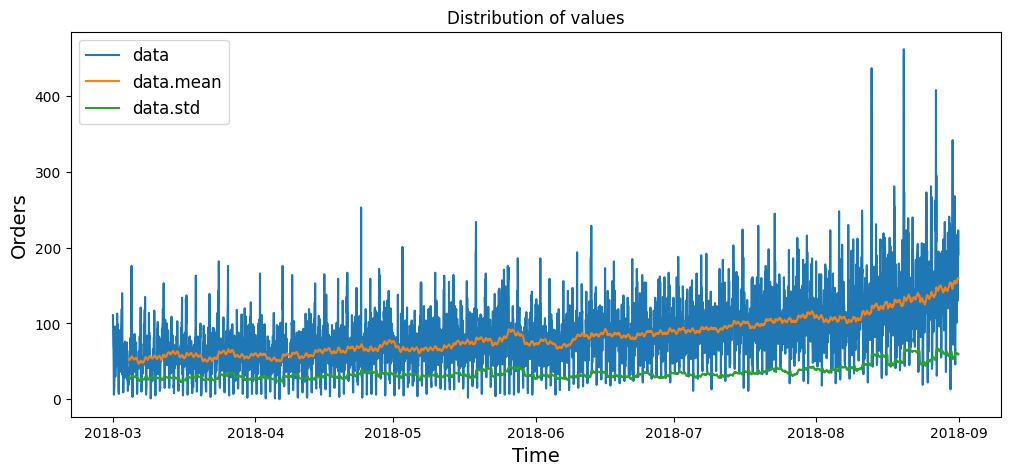

In [82]:
window = 84

plt.figure(figsize=(12, 5))

plt.plot(data, label = 'data')
plt.plot(data.rolling(window).mean(),  label = 'data.mean')
plt.plot(data.rolling(window).std(), label = 'data.std')

plt.xlabel('Time', size = 14)
plt.ylabel('Orders', size = 14)
plt.title('Distribution of values')

plt.legend(title = '', loc = 'upper left', fontsize = 12);

**Промежуточный вывод:**

Данные не статичны, так как в некоторых промежутках сильно изменяется стандартное отклонение. Видны тенденции, которые мы уточним в следующим пункте.

Разложим ряд на компоненты: тренд, сезонность и случайные колебания. Построим функцию `plot_trend_and_seasons`.

In [83]:
def plot_trend_and_seasons(date_from: str, date_to: str):
    pylab.rcParams['figure.figsize'] = (10, 7)
    seasonal_decompose(data[date_from:date_to]).plot()


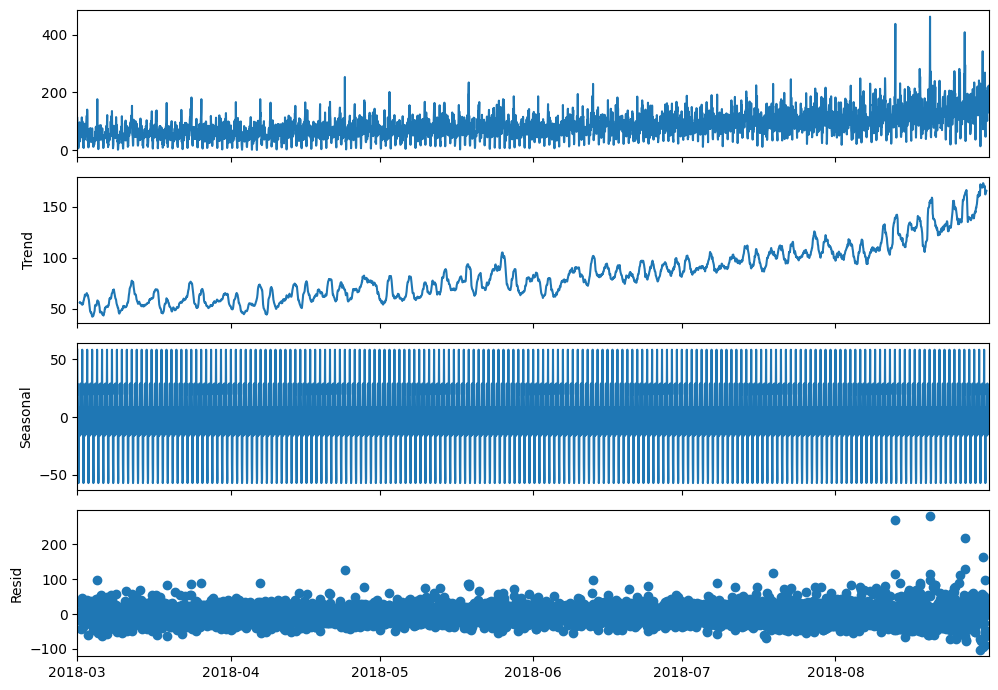

In [84]:
plot_trend_and_seasons('2018', '2018')

По графику сложно понять хоть какие-то зависимости, поэтому выберем промежуток в 2-е недели, чтобы увеличить масштаб.

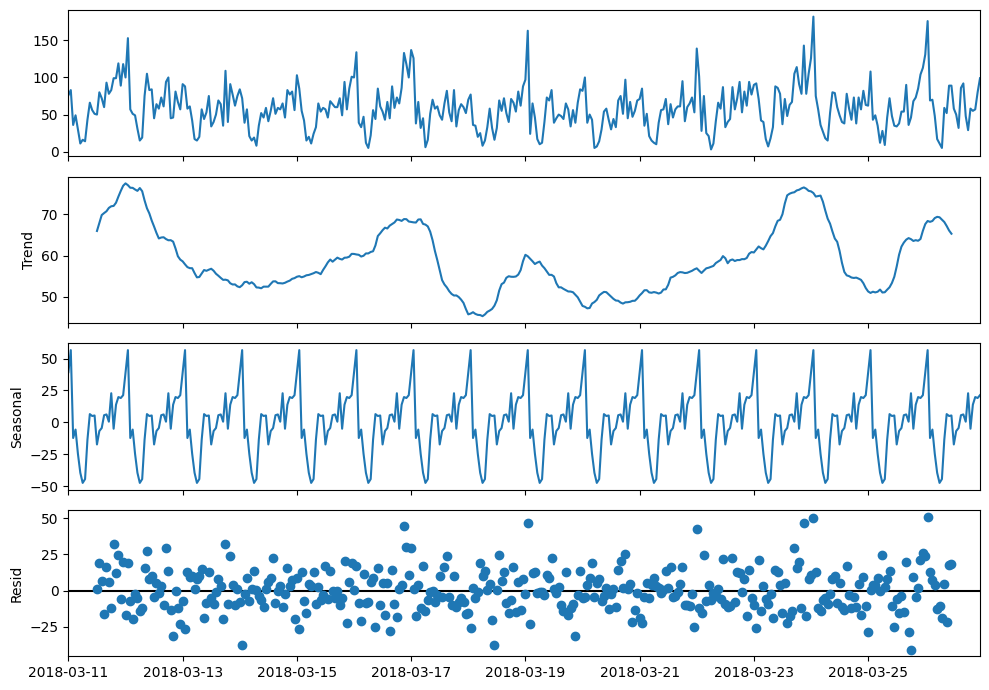

In [85]:
plot_trend_and_seasons('2018-03-11', '2018-03-26')

**Промежуточный вывод:**

Мы видим пики ближе к выходным, которые наблюдаются и в тренде, и в сезонности, что вполне объяснимо, ведь ближе к выходным люди проводят больше времени на улице и имеют возможность отдохнуть от работы, чем и обуславливается высокий спрос.

Построим матрицу автокорреляции и график.

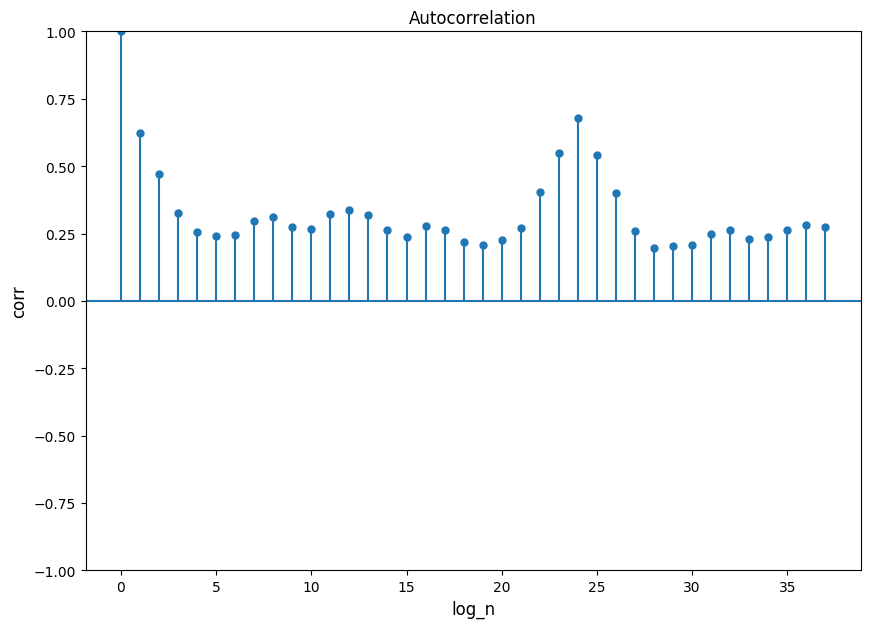

In [86]:
plot_acf(data, alpha=None)
plt.xlabel('log_n', size = 12)
plt.ylabel('corr', size = 12)
plt.show()

**Промежуточный вывод:**

Как мы видим по пикам на логах `1-2`, `7-8`, `13-14`, `19-23`, ближе к выходным наблюдается прирост, что было доказано выше.

## Обучение моделей с разными гиперпараметрами.

Для начала необходимо добавить новые признаки, чтобы наша модель лучше обучалась. Создадим функцию `make_new_features`, которая добавляет:

* `day_of_week`
* `time`
* `lags`
* `is_holiday`

In [108]:
days_hol = holidays.country_holidays("RUS")

def make_new_features(data: pd.DataFrame, max_lag: int, rolling_mean_size: float):
    data_features = data.copy()
    data_features['day_of_week'] = data_features.index.weekday
    data_features['time'] = data_features.index.hour
    data_features['is_holiday'] = data_features.index.map(lambda x: 1 if x in days_hol else 0)

    for lag in range(1, max_lag + 1):
        data_features['lag_{}'.format(lag)] = data_features['num_orders'].shift(lag)

    data_features['rolling_mean'] = data_features['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return data_features

In [109]:
data_with_features = make_new_features(data, 29, 168)

Разделим выборку на обучающую и тестовую выборки.

In [110]:
data_train, data_test = train_test_split(data_with_features, test_size=.1, shuffle=False)
data_train = data_train.dropna()

Проверим корректность разреза данных.

In [111]:
print(data_train.index.min())
print(data_test.index.max())

2018-03-08 00:00:00
2018-08-31 23:00:00


Разрез корректен.

Разделим получившиеся выборки на признаки: `features`,`target`.

In [112]:
features_train = data_train.drop('num_orders', axis = 1)
target_train = data_train.num_orders

features_test = data_test.drop('num_orders', axis = 1)
target_test = data_test.num_orders

Данные разделены, теперь можно обучать.

Обучим разные модели.

**Простые модели:**
1. LinearRegression
2. DecisionTreeRegressor
3. RandomForestRegressor

**Модели на основе градиентного бустинга:**

1. LightGBM
2. CatBoost

Подготовим словари параметров для каждой модели.

In [113]:
param_grid_forest = {
    'n_estimators': range(1, 101, 20),
    'max_depth': range(2, 6),
    'min_samples_leaf': range(1, 5, 2),
    'min_samples_split': range(2, 6, 2)
}

param_grid_tree = {
    'max_depth': range(2, 6),
    'min_samples_leaf': range(1, 5, 2),
    'min_samples_split': range(2, 6, 2)
}

param_grid_linregr = {
              'fit_intercept': [True, False],
}

param_grid_catboost = {
    'n_estimators': range(1, 100, 25),
    'learning_rate': [0.03, 0.1],
    'depth': range(2, 6)
}

param_grid_lightgbm = {
    'n_estimators': range(1, 100, 25),
    'learning_rate': [0.1, 0.01]
}

params_grid_xgb = {
    "learning_rate": (0.05, 0.1),
    "max_depth": [ 3, 4, 5, 6, 8],
    "min_child_weight": [ 1, 3, 5, 7],
    "gamma":[ 0.0, 0.1, 0.2],
}

### Простые модели

Создадим модели, и подберем параметры с помощью `GridSearchCV`.

In [114]:
model_TREE = DecisionTreeRegressor(random_state=RANDOM_STATE)
model_FOREST = RandomForestRegressor(random_state=RANDOM_STATE)
model_LINREGR = LinearRegression()

In [115]:
%%time

cv = TimeSeriesSplit(3)

grid_TREEE = GridSearchCV(model_TREE, param_grid_tree, cv = cv, scoring='neg_mean_squared_error')
grid_TREEE.fit(features_train, target_train)

grid_FOREST = GridSearchCV(model_FOREST, param_grid_forest, cv = cv, scoring='neg_mean_squared_error')
grid_FOREST.fit(features_train, target_train)

grid_LINREGR = GridSearchCV(model_LINREGR, param_grid_linregr,  cv = cv, scoring='neg_mean_squared_error')
grid_LINREGR.fit(features_train, target_train)

print('Время подбора: \n')

Время подбора: 

CPU times: user 1min 7s, sys: 553 ms, total: 1min 7s
Wall time: 1min 7s


Напишем функцию для расчета RMSE.

In [116]:
def rmse(mse: float):
    return math.sqrt(mse)

Модели обучены. Выведем подобранные параметры.

In [117]:
print(
    f'Модель DecisionTreeRegressor\n {grid_TREEE.best_params_}\nRMSE: {rmse((grid_TREEE.best_score_ * (-1)))}\n\n'
    f'Модель RandomForestRegressor\n {grid_FOREST.best_params_}\nRMSE: {rmse((grid_FOREST.best_score_ * (-1)))}\n\n'
    f'Модель LinearRegression\n: {grid_LINREGR.best_params_}\nRMSE: {rmse((grid_LINREGR.best_score_ * (-1)))}'
)

Модель DecisionTreeRegressor
 {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 4}
RMSE: 31.909362627990976

Модель RandomForestRegressor
 {'max_depth': 5, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 81}
RMSE: 28.953481630058207

Модель LinearRegression
: {'fit_intercept': False}
RMSE: 26.921487107640903


### Модели на основе градиентного бустинга

In [118]:
model_catboost = cb.CatBoostRegressor(random_state=RANDOM_STATE)
model_lightgbm = lgb.LGBMRegressor(random_state=RANDOM_STATE)
xgb_model = xgb.XGBRegressor(random_state = RANDOM_STATE)

In [121]:
%%time

grid_catboost = GridSearchCV(estimator=model_catboost,
                             param_grid=param_grid_catboost,
                             cv = cv,
                             n_jobs=-1,
                             scoring='neg_mean_squared_error')
grid_catboost.fit(features_train, target_train, verbose = False)

grid_lightgbm = GridSearchCV(estimator=model_lightgbm,
                             param_grid=param_grid_lightgbm,
                             cv = cv,
                             n_jobs=-1,
                             scoring='neg_mean_squared_error')
grid_lightgbm.fit(features_train, target_train)

grid_xgb = GridSearchCV(estimator=xgb.XGBRegressor(), 
                        param_grid=params_grid_xgb, 
                        scoring='neg_mean_squared_error')
grid_xgb.fit(features_train, target_train)

print('Время подбора:\n')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000456 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5736
[LightGBM] [Info] Number of data points in the train set: 3806, number of used features: 33
[LightGBM] [Info] Start training from score 79.071466
Время подбора:

CPU times: user 26min 18s, sys: 3.88 s, total: 26min 22s
Wall time: 8min 5s


In [122]:
print(
    f'Модель CatBoostRegressor\n {grid_catboost.best_params_}\nRMSE: {rmse(grid_catboost.best_score_ * (-1))}\n\n'
    f'Модель LGBMRegressor\n {grid_lightgbm.best_params_}\nRMSE: {rmse(grid_lightgbm.best_score_ * (-1))} \n\n'
    f'Модель XGBRegressor\n {grid_xgb.best_params_}\nRMSE: {rmse(grid_xgb.best_score_ * (-1))}'
)

Модель CatBoostRegressor
 {'depth': 5, 'learning_rate': 0.1, 'n_estimators': 76}
RMSE: 27.017099977296287

Модель LGBMRegressor
 {'learning_rate': 0.1, 'n_estimators': 76}
RMSE: 26.67481754894318 

Модель XGBRegressor
 {'gamma': 0.0, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 3}
RMSE: 23.278749617660882


**Вывод:**

По итогам исследования наилучшая модель - `XGBRegressor`.

Параметры: {'gamma': 0.0, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 3}


## Проанализируем время обучения и проверим значения на тестовой выборке

Для анализа времени обучения - создадим класс `Time`.

In [127]:
class Time:
    def __init__(self, model, model_name = ''):
        self.model = model
        self.model_name = model_name
        self.train_time = None
        self.predicts = None
        self.predict_time = None
        self.rmse = None

    def set_fit_time(self, features_time, target_time):
        start = time.time()
        self.model.fit(features_time, target_time)
        finish = time.time()
        self.train_time = finish - start

    def set_predict_time(self):
        start = time.time()
        self.predicts = self.model.predict(features_test)
        end = time.time()
        self.predict_time = end - start

    def set_quality(self):
        self.rmse = rmse(mean_squared_error(target_test, self.predicts))


Создадим экземпляры класса для выбранной модели модели.

In [128]:
model_xgb_time = Time(xgb.XGBRegressor(gamma =  0.0, learning_rate =  0.1, max_depth = 4, min_child_weight = 5), 'XGBRegressor')
model_xgb_time.set_fit_time(features_train, target_train)
model_xgb_time.set_predict_time()
model_xgb_time.set_quality()

Составим таблицу качества и времени обучения. Для этого напишем функцию.

In [129]:
exemplars_time_models = [model_xgb_time]
def print_table():
    print('|{: >23}|{: >18}|{: >18}|{: >12}|'.format('Модель', 'Время обучения', 'Время предсказания', 'RMSE'))
    for model in exemplars_time_models:
        print('|{: >23}|{: >18.5f}|{: >18.5f}|{: >12.5f}|'.format(model.model_name, model.train_time, model.predict_time, model.rmse))

In [130]:
print_table()

|                 Модель|    Время обучения|Время предсказания|        RMSE|
|           XGBRegressor|           0.13946|           0.00337|    40.15150|


## Вывод

Обученные модели дали следующие результаты:

* **DecisionTreeRegressor**:

rmse_train - 31.2404

rmse_test - 52.2256

+------------------------+

* **RandomForestRegressor**:

rmse_train - 28.8558

rmse_test - 48.4170

+------------------------+

* **LinearRegression**:

rmse_train - 26.3993

rmse_test - 45.5958

+------------------------+

+------------------------+

* **CatBoostRegressor**:

rmse_train - 27.3383

rmse_test - 46.6397

+------------------------+

* **LGBMRegressor**:

rmse_train - 26.3383

rmse_test - 40.0952

+------------------------+

* **XGBRegressor**:

rmse_train - 23.3383

rmse_test - 40.1523


Из всех моделей лучше всего показали себя **градиентные**. Однако, лучшая модель `XGBRegressor`